In [2]:
# @title #### Student Identity
student_id = "REAJN7WZ" # @param {type:"string"}
name = "Reyhan Wiranugraha" # @param {type:"string"}
drive_link = "https://drive.google.com/drive/u/0/folders/1uhnn6SaQQmo0dwiYPQqYUtKeQu26mz9K"  # @param {type:"string"}

assignment_id = "00_cnn_project"

In [3]:
!pip install rggrader
from rggrader import submit, submit_image

In [4]:
# All required package/module
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import WeightedRandomSampler

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from PIL import Image

## Task-1 Load the dataset


### I. RealWaste Image Classification

About Dataset
Overview

An image classification dataset of waste items across 9 major material types, collected within an authentic landfill environment.

dataset source:
https://www.kaggle.com/datasets/joebeachcapital/realwaste

Because of the dataset content only have images with it classes, now i want to getting CSV file from image dataset

In [6]:
# datasets/
# ├── set/
# │    ├── Cardboard/
# │    │    ├── image1.jpg
# │    │    ├── image2.jpg
# │    │    └── ...
# │    ├── Food Organics/
# │    │    ├── image1.jpg
# │    │    ├── image2.jpg
# │    │    └── ...
# │    ├── Glass/
# │    │    ├── image1.jpg
# │    │    ├── image2.jpg
# │    │    └── ...
# │    ├── Metal/
# │    │    ├── image1.jpg
# │    │    ├── image2.jpg
# │    │    └── ...
# │    ├── Miscellaneous Trash/
# │    │    ├── image1.jpg
# │    │    ├── image2.jpg
# │    │    └── ...
# │    ├── Paper/
# │    │    ├── image1.jpg
# │    │    ├── image2.jpg
# │    │    └── ...
# │    ├── Plastic/
# │    │    ├── image1.jpg
# │    │    ├── image2.jpg
# │    │    └── ...
# │    ├── Textile Trash/
# │    │    ├── image1.jpg
# │    │    ├── image2.jpg
# │    │    └── ...
# │    ├── Vegetation/
# │    │    ├── image1.jpg
# │    │    ├── image2.jpg
# │    │    └── ...
# Root directory containing the dataset
root_dir = "datasets"  # Update with your dataset directory

# Get the list of classes (subfolders) in the set image folder
classes = os.listdir(os.path.join(root_dir, "set"))

# Initialize lists to store file paths and labels
file_paths = []
labels = []

# Initialize a counter for the total number of images
train_images = 0

# Iterate over each class directory
for class_name in classes:
    class_dir_train = os.path.join(root_dir, "set", class_name)

    
    # Get the list of image files in the train and test class directories
    images_train = os.listdir(class_dir_train)
    
    # Add train file paths and labels
    for image_train in images_train:
        file_paths.append(os.path.join("set", class_name, image_train))
        labels.append(class_name)
    
    # Update the total number of images
    train_images += len(images_train)


# Create a DataFrame with file paths and labels
df = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})

# Save the DataFrame to a CSV file
df.to_csv("dataset.csv", index=False)

print(f"Total number of images in datasets/set: {train_images}")
print("CSV file created successfully.")


Total number of images in datasets/set: 8265
CSV file created successfully.


### I.1 Dataset Preview
Now we want to display a couple of images from the seg_train dataset.

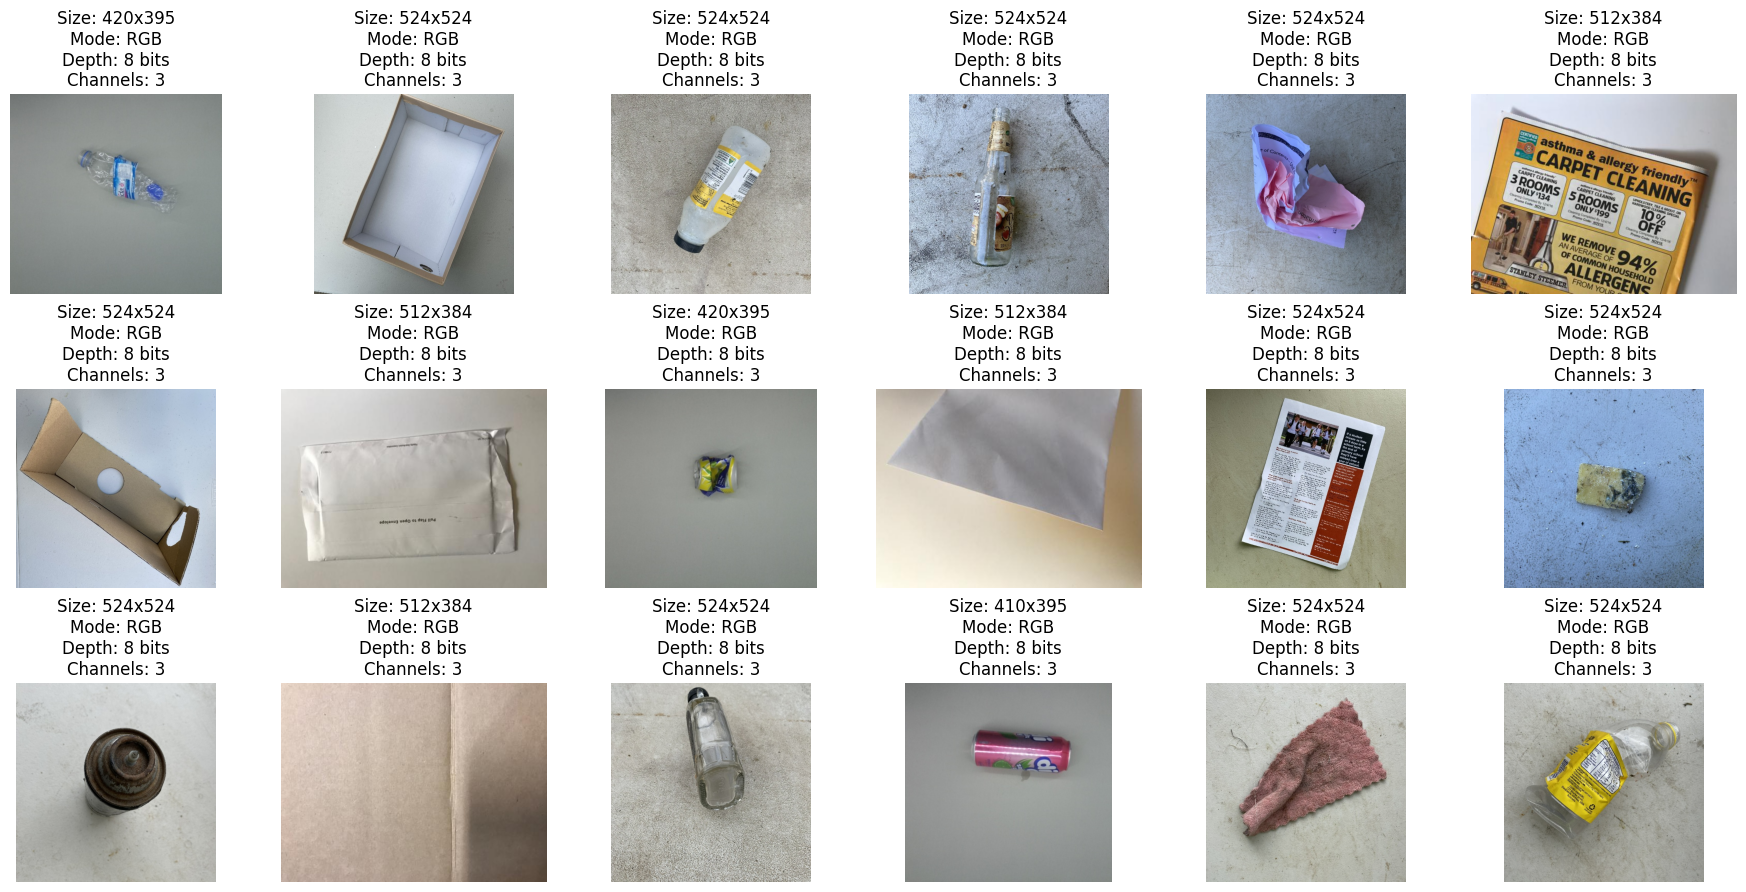

In [5]:
# Path to the training image folder
train_image_folder = "datasets/train"  # Update with your dataset directory

# Get list of image files in the training image folder
image_files = []
for class_name in os.listdir(train_image_folder):
    class_dir = os.path.join(train_image_folder, class_name)
    if os.path.isdir(class_dir):
        image_files.extend([os.path.join(class_dir, img) for img in os.listdir(class_dir)])

# Sample 18 random images
sample_images = np.random.choice(image_files, 18, replace=False)

# Plot the sample images along with their properties
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
for i, (ax, image_path) in enumerate(zip(axes.flat, sample_images)):
    # Open the image using PIL
    img = Image.open(image_path)
    # Get image properties
    width, height = img.size
    mode = img.mode  # Color mode (e.g., RGB, grayscale)
    depth = img.bits  # Depth of the image (bits per pixel)
    channels = len(img.getbands())  # Number of color channels

    # Display the image
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"Size: {width}x{height}\nMode: {mode}\nDepth: {depth} bits\nChannels: {channels}")

plt.tight_layout()
plt.show()

Hmm... Looks good, we can smell the picture from here :D

In [8]:
import pandas as pd

# Load the CSV file into a pandas DataFrame
# Replace "dataset.csv" with the actual filename of your CSV file
df = pd.read_csv("dataset.csv")

# Print the first few rows of the DataFrame
print(df.head())

# Accessing the data
file_paths = df['file_path']
labels = df['label']

                        file_path      label
0    set\Cardboard\cardboard1.jpg  Cardboard
1   set\Cardboard\cardboard10.jpg  Cardboard
2  set\Cardboard\cardboard100.jpg  Cardboard
3  set\Cardboard\cardboard101.jpg  Cardboard
4  set\Cardboard\cardboard102.jpg  Cardboard


In [ ]:
# # Path to the main dataset directory
# dataset_dir = "datasets/set"  # Update with your dataset directory

# # List all class directories
# class_dirs = [os.path.join(dataset_dir, class_name) for class_name in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, class_name))]

# # Split each class directory into train and test directories
# train_dir = "datasets/train"
# test_dir = "datasets/test"
# for class_dir in class_dirs:
#     # Create train and test directories for the class
#     train_class_dir = os.path.join(train_dir, os.path.basename(class_dir))
#     test_class_dir = os.path.join(test_dir, os.path.basename(class_dir))
#     os.makedirs(train_class_dir, exist_ok=True)
#     os.makedirs(test_class_dir, exist_ok=True)
    
#     # Split images for the class into train and test sets
#     class_files = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
#     train_files, test_files = train_test_split(class_files, test_size=0.2, random_state=42)
    
#     # Move files to train and test directories
#     for file in train_files:
#         shutil.move(file, os.path.join(train_class_dir, os.path.basename(file)))
    
#     for file in test_files:
#         shutil.move(file, os.path.join(test_class_dir, os.path.basename(file)))

In [ ]:
# Root directory containing the dataset
dataset_dir = './datasets'
os.chdir(dataset_dir)

# Get the list of classes (subfolders) in the training image folder
classes = os.listdir(os.path.join(dataset_dir, "train"))

# Initialize lists to store file paths and labels
file_paths = []
labels = []

# Initialize a counter for the total number of images
train_images = 0
test_images = 0
total_images = 0

# Iterate over each class directory
for class_name in classes:
    class_dir_train = os.path.join(dataset_dir, "train", class_name)
    class_dir_test = os.path.join(dataset_dir, "test", class_name)

    # Get the list of image files in the train and test class directories
    images_train = os.listdir(class_dir_train)
    images_test = os.listdir(class_dir_test)

    # Add train file paths and labels
    for image_train in images_train:
        file_paths.append(os.path.join("train", class_name, image_train))
        labels.append(class_name)

    # Add test file paths and labels
    for image_test in images_test:
        file_paths.append(os.path.join("test", class_name, image_test))
        labels.append(class_name)

    # Update the total number of images
    train_images += len(images_train)
    test_images += len(images_test)
    total_images += len(images_train) + len(images_test)

# Create a DataFrame with file paths and labels
df = pd.DataFrame({
    'file_path': file_paths,
    'label': labels
})

# Save the DataFrame to a CSV file
df.to_csv("dataset.csv", index=False)

print(f"Total number of images in datasets/train: {train_images}")
print(f"Total number of images in datasets/test: {test_images}")
print(f"Total number of images in datasets: {total_images}")
print("CSV file created successfully.")

: 

### 1.2 Submission

You'll submit the link to your dataset for Task-1.

- If you use existing dataset from Kaggle or Huggingface, then you can put the link to those dataset here.

- If you use your own custom dataset, Upload and store the custom dataset in your Google Drive that you shared with us and put the link to the folder containing that dataset here.

In [10]:
# Submit Method
dataset_link = "https://www.kaggle.com/datasets/reyhanwiranugraha/real-image-dataset/data" # Put your model link

question_id = "00_cnn_project_dataset"
submit(student_id, name, assignment_id, dataset_link, question_id, drive_link)

'Assignment successfully submitted'

## Task-2 Build a model

In this task, you will now build and save your model. You can either create your own CNN model or choose any pretrained model that you feel is most appropriate for your dataset.

### 2.1 Write your code in the block below

In the code block below, write the code to **create your model, either from scratch or fine tuning a pretrained model**. You will need to write the code for your model definition, such as the layers used, loss function and optimizer. Please include also the training and validation loops.

Make sure you **save your model to a file** and **measure the accuracy of your model**, as this will be submitted for this task.

Some techniques you may use:
- Use pretrained model. (Easy)
- Create a CNN model from scratch. (Hard)
- Etc.

Hint:
- Use GPU in Google Colab, it significantly improves the time taken for training, compared to CPU.
- **Google Colab GPU usage for free-tier have a limit**, which is unknown, so I suggest you try out in CPU mode that your code works without error, then use GPU for traininig.
- If you are going to upload to Huggingface by using the Transformer Trainer during training, make sure you use the Huggingface method. Refer to Transfer Learning section or read the documentation here: https://huggingface.co/docs/transformers/model_sharing

In [11]:
# Path to the main dataset directory
dataset_dir = "datasets/set"  # Update with your dataset directory

# List all class directories
class_dirs = [os.path.join(dataset_dir, class_name) for class_name in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, class_name))]

# Split each class directory into train and test directories
train_dir = "datasets/train"
test_dir = "datasets/test"
for class_dir in class_dirs:
    # Create train and test directories for the class
    train_class_dir = os.path.join(train_dir, os.path.basename(class_dir))
    test_class_dir = os.path.join(test_dir, os.path.basename(class_dir))
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)
    
    # Split images for the class into train and test sets
    class_files = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
    train_files, test_files = train_test_split(class_files, test_size=0.2, random_state=42)
    
    # Move files to train and test directories
    for file in train_files:
        shutil.move(file, os.path.join(train_class_dir, os.path.basename(file)))
    
    for file in test_files:
        shutil.move(file, os.path.join(test_class_dir, os.path.basename(file)))

### 2.1a My Own CNN Model

In [21]:
# Define data transformations and create dataloaders
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),       # Randomly rotate images by 10 degrees
    transforms.Ranz
    transforms.ToTensor(),            # Convert images to tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create a dataset from the image folder
train_data = ImageFolder(root="datasets/train", transform=train_transform)
test_data = ImageFolder(root="datasets/test", transform=test_transform)

# Create a DataLoader with the defined transformations
train_loader = DataLoader(train_data, batch_size=5, shuffle=True)
test_loader = DataLoader(test_data, batch_size=5, shuffle=False)

compute the class frequencies

In [6]:
# Compute class weights
class_counts = [train_data.targets.count(c) for c in range(len(train_data.classes))]
total_samples = sum(class_counts)
class_weights = [total_samples / (len(train_data.classes) * count) for count in class_counts]

# Create a sampler with class weights
weights = [class_weights[label] for label in train_data.targets]
sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_data), replacement=True)

# Create DataLoader with the custom sampler
train_data_gen = DataLoader(train_data, batch_size=32, sampler=sampler)

In [2]:
# Define the random seed
RS = 42  # You can choose any integer value for the seed

# Set random seed for reproducibility
torch.manual_seed(RS)
np.random.seed(RS)

# Define the CNN architecture
class CNNModel(nn.Module):
    def __init__(self, num_classes=9):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(64 * 14 * 14, 128)  # Updated input size
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = self.flatten(x,1)
        x = torch.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# Create an instance of your CNN model
num_classes = 9  # Example: adjust based on the number of classes in your dataset
model = CNNModel(num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):  # Example: 10 epochs
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader)
    epoch_loss = train_loss / len(train_data)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy}")

# Make predictions
pred_test = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        pred_test.extend(predicted.tolist())

# Compute confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
true_labels = [label.item() for _, label in test_data]
cm = confusion_matrix(true_labels, pred_test)
acc = accuracy_score(true_labels, pred_test)
print("Confusion Matrix:")
print(cm)
print("Accuracy:", acc)

NameError: name 'torch' is not defined

### 2.1b Fine-tuning VGG16 as CNN Model

In [6]:
# Initialize WandB with existing project
wandb.init(project="real-waste-project", entity="eunoiawiira")

def log_image_table(inputs, predicted, labels, probs):
    "Log a wandb.Table with (img, pred, target, scores)"
    # 🐝 Create a wandb Table to log images, labels and predictions to
    table = wandb.Table(columns=["inputs", "pred", "target"]+[f"score_{i}" for i in range(10)])
    for img, pred, targ, prob in zip(inputs.to("cpu"), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
        table.add_data(wandb.Image(img[0].numpy()*255), pred, targ, *prob.numpy())
    wandb.log({"predictions_table":table}, commit=False)

# Define data transformations for training and testing
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(300),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize(350),  # Resize to a slightly larger size
    transforms.CenterCrop(224),  # Center crop to 224x224 for VGG16
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset with data augmentation for training and without augmentation for testing
train_data = ImageFolder(root="datasets/train", transform=train_transform)
test_data = ImageFolder(root="datasets/test", transform=test_transform)

# Define dataloaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Load pre-trained VGG model
vgg = models.vgg16(pretrained=True)

# Modify last fully connected layer to match the number of classes in your dataset
num_classes = 9
vgg.classifier[6] = nn.Linear(4096, num_classes)

# Optionally, freeze pre-trained layers
# for param in vgg.features.parameters():
#     param.requires_grad = False

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.parameters(), lr=0.0001)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)

# Log model to WandB
wandb.watch(vgg)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    vgg.train()
    running_loss = 0.0
    for step, (inputs, labels) in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        if (step+1) % 5 == 0:
            wandb.log({"Train Loss": loss.item()})
        if (step+1) % 5 == 0:  # Print every 5 steps
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}")
    

# Validation
    vgg.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = vgg(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(test_data)
    accuracy = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")
    wandb.log({"Validation Loss": val_loss, "Validation Accuracy": accuracy})
    # Log predictions table periodically
    if total % 100 == 0:
      probabilities = torch.softmax(outputs, dim=1)
      log_image_table(inputs, predicted, labels, probabilities)

# Save the model
torch.save(vgg.state_dict(), "eunoiawiira-vgg-realwaste-classification.pth")

# 🐝 Close your wandb run
wandb.finish()

Epoch 1/10, Train Loss: 1.3673
Epoch 2/10, Train Loss: 0.8643
Epoch 3/10, Train Loss: 0.7485
Epoch 4/10, Train Loss: 0.6573
Epoch 5/10, Train Loss: 0.5859
Epoch 6/10, Train Loss: 0.5114
Epoch 7/10, Train Loss: 0.4866
Epoch 8/10, Train Loss: 0.4747
Epoch 9/10, Train Loss: 0.3935
Epoch 10/10, Train Loss: 0.3571
Test Accuracy: 0.8365


In [7]:
# Submit Method
model_link = "https://drive.google.com/file/d/19OfH0mJCo7AAutotlukPEqtxxQDZBqkU/view?usp=sharing" # Put your model link

question_id = "01_cnn_project_model_link"
submit(student_id, name, assignment_id, model_link, question_id, drive_link)
question_id = "02_cnn_project_model_accuracy"
submit(student_id, name, assignment_id, str(accuracy), question_id, drive_link)

'Assignment successfully submitted'

### 2.1c Fine-tuning AlexNet as CNN Model

In [ ]:
# Initialize WandB with existing project
# wandb.init(project="real-waste-project", entity="eunoiawiira")

# def log_image_table(inputs, predicted, labels, probs):
#     "Log a wandb.Table with (img, pred, target, scores)"
#     # 🐝 Create a wandb Table to log images, labels and predictions to
#     table = wandb.Table(columns=["inputs", "pred", "target"]+[f"score_{i}" for i in range(10)])
#     for img, pred, targ, prob in zip(inputs.to("cpu"), predicted.to("cpu"), labels.to("cpu"), probs.to("cpu")):
#         table.add_data(wandb.Image(img[0].numpy()*255), pred, targ, *prob.numpy())
#     wandb.log({"predictions_table":table}, commit=False)

# Define data transformations for training and testing
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

class AlexNet(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 33, kernel_size=12, stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=6, stride=2),
            nn.Conv2d(33, 65, kernel_size=6),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=6, stride=2),
            nn.Conv2d(65, 131, kernel_size=6),
            nn.ReLU(inplace=True),
            nn.Conv2d(131, 262, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.Conv2d(262, 524, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(524 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Create an instance of AlexNet for classification
model = AlexNet(num_classes=9)  # Assuming 9 output classes
print(model)

# Load dataset with data augmentation for training and without augmentation for testing
train_data = ImageFolder(root='/content/drive/My Drive/Colab Notebooks/Bootcamp/Project/Project_08/datasets/train', transform=train_transform)
test_data = ImageFolder(root='/content/drive/My Drive/Colab Notebooks/Bootcamp/Project/Project_08/datasets/test', transform=test_transform)

# Define dataloaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# # Log model to WandB
# wandb.watch(model)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for step, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        # if (step+1) % 10 == 0:
        #     wandb.log({"Train Loss": loss.item()})
        if (step+1) % 10 == 0:  # Print every 10 steps
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{step+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_data)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")
    # wandb.log({"Epoch": epoch+1, "Train Loss": epoch_loss})

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)  # Use logits instead of outputs directly
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)  # Use logits for prediction
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(test_data)
    accuracy = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")
    # wandb.log({"Validation Loss": val_loss, "Validation Accuracy": accuracy})
    # Log predictions table periodically
    if total % 100 == 0:
      probabilities = torch.softmax(outputs, dim=1)
      log_image_table(inputs, predicted, labels, probabilities)


# Save the model
model_path = "eunoiawiira_alexnet_finetuned_realwaste.pth"
torch.save(model.state_dict(), model_path)

# # 🐝 Close your wandb run
# wandb.finish()

In [ ]:
# Define your own CNN model
class YourCNNModel(nn.Module):
    def __init__(self, num_classes):
        super(YourCNNModel, self).__init__()
        # Define your architecture
        # Example:
        # self.conv1 = nn.Conv2d(...)
        # self.fc1 = nn.Linear(...)
        # ...
        self.num_classes = num_classes

    def forward(self, x):
        # Define the forward pass
        return x

# Define data transformations for training and testing
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize(256),  # Resize to match input size of pretrained models
    transforms.CenterCrop(224),  # Center crop to match input size of pretrained models
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset with data augmentation for training and without augmentation for testing
train_data = ImageFolder(root='/content/drive/My Drive/Colab Notebooks/Bootcamp/Project/Project_08/datasets/train', transform=train_transform)
test_data = ImageFolder(root='/content/drive/My Drive/Colab Notebooks/Bootcamp/Project/Project_08/datasets/test', transform=test_transform)

# Split the training data into training and validation sets
train_size = int(0.8 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Define dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Define your models
your_model = YourCNNModel(num_classes=len(train_data.classes))
vgg16 = models.vgg16(pretrained=True)
inception_v3 = models.inception_v3(pretrained=True)

# Freeze parameters in pretrained models
for param in vgg16.parameters():
    param.requires_grad = False
for param in inception_v3.parameters():
    param.requires_grad = False

# Modify the fully connected layer of VGG16 and InceptionV3 to match the number of classes
vgg16.classifier[6] = nn.Linear(4096, len(train_data.classes))
inception_v3.fc = nn.Linear(2048, len(train_data.classes))

# Define loss function and optimizer for all models
criterion = nn.CrossEntropyLoss()
optimizer_your_model = optim.Adam(your_model.parameters(), lr=0.0001)
optimizer_vgg16 = optim.Adam(vgg16.classifier.parameters(), lr=0.0001)
optimizer_inception_v3 = optim.Adam(inception_v3.fc.parameters(), lr=0.0001)

# Train your model
def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")

        # Validate the model
        val_loss, val_accuracy = evaluate_model(model, criterion, val_loader)
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    print("Training finished.")

# Evaluate model
def evaluate_model(model, criterion, data_loader):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / len(data_loader.dataset)
    accuracy = correct / total
    return loss, accuracy

# Train your model
train_model(your_model, optimizer_your_model, criterion, train_loader, val_loader, num_epochs=10)
train_model(vgg16, optimizer_vgg16, criterion, train_loader, val_loader, num_epochs=10)
train_model(inception_v3, optimizer_inception_v3, criterion, train_loader, val_loader, num_epochs=10)

# Evaluate models on test data
loss_your_model, accuracy_your_model = evaluate_model(your_model, criterion, test_loader)
loss_vgg16, accuracy_vgg16 = evaluate_model(vgg16, criterion, test_loader)
loss_inception_v3, accuracy_inception_v3 = evaluate_model(inception_v3, criterion, test_loader)

# Compare accuracies
print("Your Model Test Accuracy:", accuracy_your_model)
print("VGG16 Test Accuracy:", accuracy_vgg16)
print("InceptionV3 Test Accuracy:", accuracy_inception_v3)

Submit

In [ ]:
# Submit Method
model_link = "https://drive.google.com/file/d/1lp1o9tbiLNF0ig8uu_lx2MjZltapXfF7/view?usp=sharing" # Put your model link

question_id = "01_cnn_project_model_link"
submit(student_id, name, assignment_id, model_link, question_id, drive_link)
question_id = "02_cnn_project_model_accuracy"
submit(student_id, name, assignment_id, str(accuracy), question_id, drive_link)

## Task-3 Model Inference

In this task, you will be exercising the application of your model, or as it's commonly referred to in AI terminology, you will be performing inference using your model.

Simply load your saved model from Task-2 and create an inference for the model. Where you'll feed an image as input and the model will output the label as well as the percentage of confidence for the label.

### 3.1 Write your code in the block below

In the code block below write the code to use the model you created in Task-2. Load the model and input image, afterwards, show the result of the label/class together with confidence level in percentage as well as the input image.

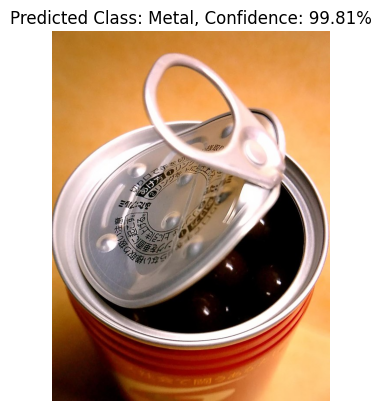

In [14]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np

# Load the saved model
model = models.vgg16(pretrained=False)
model.classifier[-1] = torch.nn.Linear(model.classifier[-1].in_features, num_classes)
model.load_state_dict(torch.load("eunoiawiira-vgg-realwaste-classification.pth"))
model.eval()

# Define transformations for input image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Function to perform inference
def predict(image_path, model, transform):
    # Open and preprocess the image
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension

    # Perform inference
    with torch.no_grad():
        output = model(image)
        probabilities = torch.softmax(output, dim=1)[0]

    # Get predicted label and confidence score
    confidence, predicted_class = torch.max(probabilities, 0)
    predicted_label = train_data.classes[predicted_class.item()]

    # Convert confidence score to percentage
    confidence_percentage = confidence.item() * 100

    return predicted_label, confidence_percentage

# Load and display the input image with its predicted label and confidence score
image_path = "wikipedia_can.jpg"
predicted_label, confidence_percentage = predict(image_path, model, transform)
image = Image.open(image_path)
plt.imshow(image)
plt.axis("off")
plt.title((f"Predicted Class: {predicted_label}, Confidence: {confidence_percentage:.2f}%"))
plt.show()


In [15]:
# Submit Method

question_id = "03_cnn_project_inference"
submit_image(student_id, question_id, './submission.jpg')

'Assignment successfully submitted'

## Task-4 Model Publishing

In this task, you will push your model to Huggingface. Once you've pushed your model to the Hugging Face Model Hub, you'll have a link that points directly to your model's page. You can share this link with others, and they can use it to directly load your model for their own uses.

### 4.1 Write your code in the block below

In the code block below, write the code to push your model to Huggingface. There are several methods to do this, please refer to the documentation: https://huggingface.co/docs/transformers/model_sharing

Some techniques you may use:
- If you use the Transformer Trainer during the training loop when you create your model above, then you can simply put your `trainer.push_to_hub()` here.
- You can also use the web interface on Huggingface.

Hint:
- Remember to login first to your Huggingface account.
- If you are pushing programmaticaly, then use the huggingface-cli to login.

In [16]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
import transformers
import torch
import datasets
import tokenizers

print(transformers.__version__)
print(torch.__version__)
print(datasets.__version__)
print(tokenizers.__version__)

4.37.1
2.1.2+cu121
2.16.1
0.15.1


In [7]:
# Submit Method
huggingface_model_link = "https://huggingface.co/EunoiaWiira/eunoiawiira-vgg-realwaste-classification" # Put your model link

question_id = "04_cnn_project_publish"
submit(student_id, name, assignment_id, huggingface_model_link, question_id, drive_link)

'Assignment successfully submitted'